In [84]:
import numpy as np
import pandas as pd
import os
import glob
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
import yfinance as yf

In [85]:
DATA_PATH    = 'downloader-data'
TICKERS_PATH = 'tickers'

## 1 - data collection

### read tickers

In [86]:
ticker_files = glob.glob(f'{TICKERS_PATH}/*')
ticker_dfs = []
for tf in ticker_files[1:]:
    ticker_dfs.append(pd.read_csv(tf))

tickers = pd.concat(ticker_dfs, ignore_index=True)


### read data

In [87]:
data_for_ticker = {}
for index, (ticker, name) in tickers.iterrows():
    try:
        df = pd.read_csv(f'{DATA_PATH}/{ticker}.csv')
        if len(df) > 100:
            data_for_ticker[ticker] = df
    except:
        pass
    
print(data_for_ticker['AAPL'])

           Date       Close     Volume
0    2020-10-27  116.599998   92276800
1    2020-10-28  111.199997  143937800
2    2020-10-29  115.320000  146129200
3    2020-10-30  108.860001  190272600
4    2020-11-02  108.769997  122866900
..          ...         ...        ...
248  2021-10-21  149.479996   61421000
249  2021-10-22  148.690002   58839600
250  2021-10-25  148.639999   50720600
251  2021-10-26  149.320007   60893400
252  2021-10-27  148.850006   55951800

[253 rows x 3 columns]


## 2 - assets map

In [88]:
for ticker, data in data_for_ticker.items():
    data_for_ticker[ticker] = data.assign(logret=np.log(data.Close).diff())
    data_for_ticker[ticker]['minus_logret'] = data_for_ticker[ticker]['logret'].mul(-1)

In [89]:
data_for_ticker['AAPL']

,Date,Close,Volume,logret,minus_logret
0,2020-10-27,116.599998,92276800,NaN,NaN
1,2020-10-28,111.199997,143937800,-0.047419,0.047419
2,2020-10-29,115.320000,146129200,0.036381,-0.036381
3,2020-10-30,108.860001,190272600,-0.057648,0.057648
4,2020-11-02,108.769997,122866900,-0.000827,0.000827
...,...,...,...,...,...
248,2021-10-21,149.479996,61421000,0.001473,-0.001473
249,2021-10-22,148.690002,58839600,-0.005299,0.005299
250,2021-10-25,148.639999,50720600,-0.000336,0.000336
251,2021-10-26,149.320007,60893400,0.004564,-0.004564


### compute logret_mean, logret_std

In [90]:
estims = pd.DataFrame(data=[], columns=['ticker', 'logret_mean', 'logret_std'])
estims.set_index('ticker', inplace=True)

for ticker, data in data_for_ticker.items():
    estims.loc[ticker] = [data['logret'].mean(), data['logret'].std()]
    
estims

,logret_mean,logret_std
ticker,,
YNDX,0.001073,0.019525
ROSN,0.005203,0.124752
ALRS,0.001398,0.025130
MGNT,-0.027981,0.522049
POLY,0.001039,0.042375
...,...,...
CONTROLPR,-0.001061,0.026090
CORALFINAC,-0.001317,0.034008
CORDSCABLE,-0.001831,0.024574


### plot the map

In [91]:
import plotly.express as px
from sklearn.preprocessing import normalize

ticker_colour = estims['logret_mean'] / estims['logret_std']
ticker_size = (ticker_colour - ticker_colour.min()) / ticker_colour.max()
fig = px.scatter(estims, x='logret_std', y='logret_mean',
                 hover_name=estims.index, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=ticker_colour)
fig.show()

In [92]:
ticker_colour.sort_values(ascending=False)
portfolio = ticker_colour.sort_values(ascending=False)[:50]
tickers = portfolio.keys()
tickers = list(tickers)
print(tickers)

['PRFT', 'ANAT', 'III', 'WIRE', 'OFS', 'DXLG', 'PMBC', 'FTNT', 'CG', 'GAIN', 'SBNY', 'TGA', 'TRNS', 'AAVAS', 'PDBC', 'JYNT', 'CRAI', 'CSWC', 'ARLP', 'UHAL', 'ADANIGREEN', 'JCOM', 'ATLC', 'ORMP', 'NYMTP', 'CBNK', 'GOOG', 'TBBK', 'TGLS', 'HMNF', 'ANGO', 'PNNT', 'COMT', 'ARCC', 'GOOGL', 'HMHC', 'OMCL', 'SFBS', 'LPLA', 'VNOM', 'NDAQ', 'RDVY', 'CAR', 'SLCT', 'GLAD', 'WVVI', 'SIVB', 'BRKR', 'CRVL', 'PFLT']


In [93]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[tickers[0]]['Date'][1:]

for ticker in tickers:
    data = data_for_ticker[ticker]
    joint_data[ticker] = data['logret'][1:]
    
joint_data = joint_data.dropna()
del joint_data['Date']
joint_data


,PRFT,ANAT,III,WIRE,OFS,DXLG,PMBC,FTNT,CG,GAIN,...,NDAQ,RDVY,CAR,SLCT,GLAD,WVVI,SIVB,BRKR,CRVL,PFLT
1,-0.060564,-0.015323,-0.014670,-0.021321,-0.019513,-0.036368,0.000000,-0.043432,-0.023956,-0.037696,...,-0.027308,-0.031135,-0.023054,-0.023083,-0.021113,-0.003236,-0.038801,-0.034556,-0.015496,-0.046114
2,-0.008811,0.015613,0.000000,0.004994,-0.012392,0.000000,0.000000,-0.008019,0.015773,-0.015729,...,0.002298,0.015180,0.042868,0.059978,0.021113,0.001619,0.012594,0.018023,0.012766,0.007624
3,0.019078,-0.003917,0.009804,0.000866,-0.010025,-0.037740,-0.002692,-0.066846,-0.025358,0.015729,...,-0.008395,-0.006429,-0.086170,-0.036895,0.017944,-0.011391,0.030137,0.013013,-0.002518,-0.012739
4,0.024967,0.025685,0.019324,0.020774,0.019951,0.000000,0.039635,0.001991,0.018685,0.019026,...,0.017939,0.017124,-0.098225,0.044627,0.005457,0.008150,0.054491,0.034426,0.013934,0.032790
5,0.043856,0.023797,0.018958,0.009703,-0.007435,0.037740,0.077249,0.016323,-0.001971,0.008211,...,0.013947,0.024182,0.001637,0.035313,-0.012320,-0.009788,0.011627,-0.001136,-0.069843,0.004951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.000165,-0.003372,-0.017253,0.014772,0.000000,-0.081009,0.023175,-0.001205,-0.010578,0.003540,...,0.001417,-0.003698,0.030149,0.040719,0.000879,0.135678,-0.005954,-0.011995,-0.018415,0.003772
241,0.023865,0.002951,0.006671,0.007353,0.006626,0.052460,-0.001994,-0.000717,0.007538,0.002118,...,-0.001012,-0.003298,0.074133,0.000985,-0.004403,-0.010974,-0.011195,-0.009224,0.014019,0.003758
242,0.020148,-0.003162,-0.003997,-0.003573,-0.007576,0.003401,-0.007011,0.011416,0.011703,0.024383,...,-0.000304,0.000206,-0.023282,-0.033528,0.000000,-0.003454,0.013009,-0.009176,-0.007488,-0.003758
243,0.027634,-0.001003,-0.008043,0.041313,0.029965,0.003390,-0.024416,0.011893,0.028477,0.001376,...,0.016179,0.021041,-0.017977,-0.015385,0.004403,0.016473,0.023928,0.019318,0.018180,0.000000


### Compute logret_mean,  logret_std for the tickers 

In [94]:
logret_mean = joint_data.mean()
logret_std =  joint_data.cov()

### Compute logret_mean, logret_std by portfolio weights

In [95]:
import math

def get_portfolio_coordinates(weights,
                              _tickers=tickers,
                              _logret_mean=logret_mean,
                              _logret_std=logret_std):
    portfolio_logret_mean = 0
    portfolio_logret_std = 0
     
    for i in range(len(_tickers)):
        portfolio_logret_mean += weights[i] * _logret_mean[i]
        for j in range(len(_tickers)):
            portfolio_logret_std += weights[i] * weights[j] * _logret_std.loc[_tickers[i], _tickers[j]]
            
    portfolio_logret_std = math.sqrt(portfolio_logret_std)
    return portfolio_logret_std, portfolio_logret_mean 

### Uniform portfolio logret_mean, logret_std

In [96]:
uniform_weights = [1/len(tickers)]*len(tickers)
uniform_logret_std, uniform_logret_mean = get_portfolio_coordinates(uniform_weights)
print(f'Uniform portfolio (std, mean): ({uniform_logret_std}, {uniform_logret_mean})')

Uniform portfolio (std, mean): (0.01075279474870792, 0.003936162301835164)


In [99]:
import random

def getRandomWeights(n, shorts=False):
    left, right = 0, 100    
    if shorts:
        left = -100     
    weights = [random.randint(left, right) for i in range(0, n)]
    weights = [weight/sum(map(abs, weights)) for weight in weights]
    return weights

## Portfolio without short sales

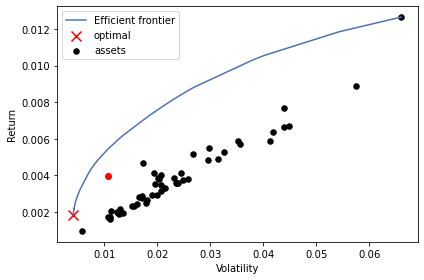

In [100]:
import matplotlib.pyplot as plt

ef_no_shorts = CLA(logret_mean, logret_std, weight_bounds=(0,1))

minvol_ef = ef_no_shorts.min_volatility()
minvol_ef_pwt = ef_no_shorts.clean_weights()


ef_plt_no_shorts = efficient_frontier_no_shorts = pplt.plot_efficient_frontier(ef_no_shorts, showfig = False)
ef_plt_no_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')

In [ ]:
# generate random sample portfolios
n_samples = 500
samples = pd.DataFrame(data=[], columns=['mean', 'std', 'weights'])

for k in range(0, n_samples):
    portfolio_weights = getRandomWeights(n=len(tickers), shorts=False)
    portfolio_std, portfolio_mean = get_portfolio_coordinates(portfolio_weights)              
    samples.loc[k] = [portfolio_mean, portfolio_std, portfolio_weights]   
    
# plot 
import plotly.express as px
from sklearn.preprocessing import normalize

sample_colour = samples['mean'] / samples['std']
sample_size = (sample_colour - sample_colour.min()) / sample_colour.max()
fig = px.scatter(samples, x=samples['std'], y=samples['mean'],
                 hover_name=samples.weights, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=sample_colour)

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False,)

fig.show()

## Efficient frontier with short sales: 

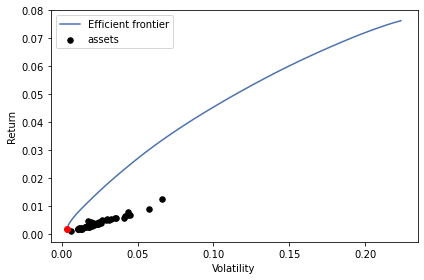

In [101]:
ef_shorts = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))
ef_shorts_copy = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))


minvol_ef_shorts = ef_shorts_copy.min_volatility()
minvol_ef_shorts_pwt = ef_shorts_copy.clean_weights()
minvol_ef_shorts_pwt = list(minvol_ef_shorts_pwt.values())

minvol_logret_std, minvol_logret_mean = get_portfolio_coordinates(minvol_ef_shorts_pwt)

ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(minvol_logret_std, minvol_logret_mean, '-ro', label='uniform portfolio')

In [18]:
# generate random sample portfolios
n_samples = 500
samples = pd.DataFrame(data=[], columns=['mean', 'std', 'weights'])

for k in range(0, n_samples):
    portfolio_weights = getRandomWeights(n=len(tickers), shorts=True)
    portfolio_std, portfolio_mean = get_portfolio_coordinates(portfolio_weights)              
    samples.loc[k] = [portfolio_mean, portfolio_std, portfolio_weights]   
    
# plot 
import plotly.express as px
from sklearn.preprocessing import normalize

sample_colour = samples['mean'] / samples['std']
sample_size = (sample_colour - sample_colour.min()) / sample_colour.max()
fig = px.scatter(samples, x=samples['std'], y=samples['mean'],
                 hover_name=samples.weights, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=sample_colour)

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False,)

fig.show()

## Portfolio with short sales with 10 stocks

In [102]:
tickers10 = tickers[:10]
tickers10

['PRFT', 'ANAT', 'III', 'WIRE', 'OFS', 'DXLG', 'PMBC', 'FTNT', 'CG', 'GAIN']

In [103]:
joint_data10 = pd.DataFrame(data=[], columns=[])
joint_data10['Date'] = data_for_ticker[tickers10[0]]['Date'][1:]

for ticker in tickers10:
    data = data_for_ticker[ticker]
    joint_data10[ticker] = data['logret'][1:]
    
joint_data10 = joint_data10.dropna()
del joint_data10['Date']
joint_data10

,PRFT,ANAT,III,WIRE,OFS,DXLG,PMBC,FTNT,CG,GAIN
1,-0.060564,-0.015323,-0.014670,-0.021321,-0.019513,-0.036368,0.000000,-0.043432,-0.023956,-0.037696
2,-0.008811,0.015613,0.000000,0.004994,-0.012392,0.000000,0.000000,-0.008019,0.015773,-0.015729
3,0.019078,-0.003917,0.009804,0.000866,-0.010025,-0.037740,-0.002692,-0.066846,-0.025358,0.015729
4,0.024967,0.025685,0.019324,0.020774,0.019951,0.000000,0.039635,0.001991,0.018685,0.019026
5,0.043856,0.023797,0.018958,0.009703,-0.007435,0.037740,0.077249,0.016323,-0.001971,0.008211
...,...,...,...,...,...,...,...,...,...,...
241,0.023865,0.002951,0.006671,0.007353,0.006626,0.052460,-0.001994,-0.000717,0.007538,0.002118
242,0.020148,-0.003162,-0.003997,-0.003573,-0.007576,0.003401,-0.007011,0.011416,0.011703,0.024383
243,0.027634,-0.001003,-0.008043,0.041313,0.029965,0.003390,-0.024416,0.011893,0.028477,0.001376
244,-0.008350,-0.001269,-0.024524,0.027105,0.015561,0.036549,-0.020812,0.004705,0.003115,0.010937


In [104]:
logret_mean10 = joint_data10.mean()
logret_std10 =  joint_data10.cov()

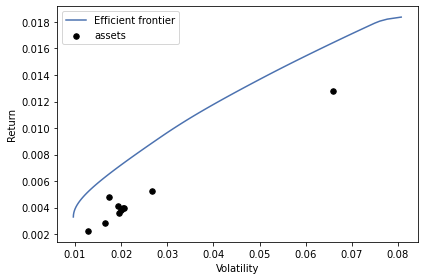

In [111]:
ef_shorts10 = EfficientFrontier(logret_mean10, logret_std10, weight_bounds=(-1,1))
ef_plt_shorts10 = pplt.plot_efficient_frontier(ef_shorts10, showfig = False)

## Portfolio without short sales with 10 stocks

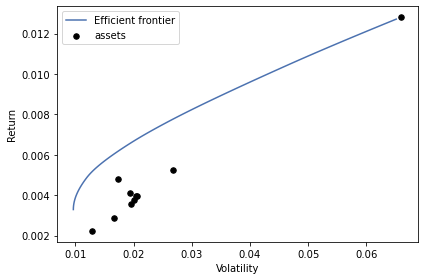

In [112]:
ef_no_shorts10 = EfficientFrontier(logret_mean10, logret_std10, weight_bounds=(0,1))
ef_plt_no_shorts10 = pplt.plot_efficient_frontier(ef_no_shorts10, showfig = False)

## Optimal portfolio without short sales with 50 stocks

In [118]:
ef_no_shorts = CLA(logret_mean, logret_std, weight_bounds=(0,1))
optimal_pfolio = ef_no_shorts.max_sharpe() 
optimal_pwt = ef_no_shorts.clean_weights()
optimal_pwt

OrderedDict([('PRFT', 0.03744),
             ('ANAT', 0.06239),
             ('III', 0.01159),
             ('WIRE', 0.0),
             ('OFS', 0.0566),
             ('DXLG', 0.02826),
             ('PMBC', 0.03691),
             ('FTNT', 0.05087),
             ('CG', 0.0),
             ('GAIN', 0.0),
             ('SBNY', 0.0),
             ('TGA', 0.02781),
             ('TRNS', 0.04129),
             ('AAVAS', 0.11706),
             ('PDBC', 0.0),
             ('JYNT', 0.00758),
             ('CRAI', 0.00654),
             ('CSWC', 0.0),
             ('ARLP', 0.0),
             ('UHAL', 0.00983),
             ('ADANIGREEN', 0.05649),
             ('JCOM', 0.0),
             ('ATLC', 0.0),
             ('ORMP', 0.00357),
             ('NYMTP', 0.15066),
             ('CBNK', 0.0),
             ('GOOG', 0.0),
             ('TBBK', 0.0),
             ('TGLS', 0.0031),
             ('HMNF', 0.16727),
             ('ANGO', 0.0),
             ('PNNT', 0.0),
             ('COMT', 0.0),
   

## Optimal portfolio with short sales with 50 stocks

In [117]:
ef_shorts = CLA(logret_mean, logret_std, weight_bounds=(-1,1))
optimal_pfolio_short = ef_shorts.max_sharpe() 
optimal_pwt_short = ef_shorts.clean_weights()
optimal_pwt_short

OrderedDict([('PRFT', 0.09849),
             ('ANAT', 0.09696),
             ('III', 0.02646),
             ('WIRE', 0.03686),
             ('OFS', 0.04254),
             ('DXLG', 0.03016),
             ('PMBC', 0.10716),
             ('FTNT', 0.05228),
             ('CG', 0.03452),
             ('GAIN', 0.10105),
             ('SBNY', 0.08804),
             ('TGA', 0.03658),
             ('TRNS', 0.06205),
             ('AAVAS', 0.13211),
             ('PDBC', 0.17427),
             ('JYNT', 0.01937),
             ('CRAI', 0.03044),
             ('CSWC', -0.01745),
             ('ARLP', 0.02494),
             ('UHAL', 0.09452),
             ('ADANIGREEN', 0.05013),
             ('JCOM', -0.03548),
             ('ATLC', 0.0094),
             ('ORMP', -0.00638),
             ('NYMTP', 0.22088),
             ('CBNK', 0.03119),
             ('GOOG', 0.06293),
             ('TBBK', -0.01849),
             ('TGLS', 0.00881),
             ('HMNF', 0.16026),
             ('ANGO', -0.01892),
 

## Optimal portfolio without short sales with 10 stocks

In [114]:
ef_no_shorts10 = CLA(logret_mean10, logret_std10, weight_bounds=(0,1))
optimal_pfolio10 = ef_no_shorts10.max_sharpe() 
optimal_pwt10 = ef_no_shorts10.clean_weights()
optimal_pwt10

OrderedDict([('PRFT', 0.20491),
             ('ANAT', 0.12414),
             ('III', 0.09254),
             ('WIRE', 0.0),
             ('OFS', 0.16982),
             ('DXLG', 0.06099),
             ('PMBC', 0.15155),
             ('FTNT', 0.15425),
             ('CG', 0.00409),
             ('GAIN', 0.03772)])

## Optimal portfolio with short sales with 10 stocks

In [116]:
ef_shorts10 = CLA(logret_mean10, logret_std10, weight_bounds=(-1,1))
optimal_pfolio_short10 = ef_shorts10.max_sharpe() 
optimal_pwt_short10 = ef_shorts10.clean_weights()
optimal_pwt_short10

OrderedDict([('PRFT', 0.2079),
             ('ANAT', 0.12556),
             ('III', 0.09299),
             ('WIRE', -0.00932),
             ('OFS', 0.17047),
             ('DXLG', 0.06107),
             ('PMBC', 0.1533),
             ('FTNT', 0.15406),
             ('CG', 0.00552),
             ('GAIN', 0.03845)])